In [10]:
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import urllib.request as urllib
from bs4 import BeautifulSoup
import requests
from scipy.stats.stats import pearsonr
import random
import matplotlib.pyplot as plt

#Here im using the cat_scores json file and the subreddits_tweaked csv

with open('posts_cat_scores.json') as f:
    all_posts = json.load(f)
    
df = pd.read_csv('subreddits_tweaked.csv')

df


,Unnamed: 0,Name,Acronym,Simple,NoSpace,Subreddits
0,7.0,Auburn University at Montgomery,AUaM,Auburn,AuburnUniversityatMontgomery,auburn
1,8.0,Auburn University,AU,Auburn,AuburnUniversity,auburn
2,10.0,Concordia College Alabama,CCA,Concordia,ConcordiaCollegeAlabama,Concordia
3,17.0,University of Mobile,UoM,Mobile,UniversityofMobile,Universityofmobile
4,18.0,University of Montevallo,UoM,Montevallo,UniversityofMontevallo,Montevallo
...,...,...,...,...,...,...
379,1469.0,Stanford University,SU,Stanford,StanfordUniversity,stanford
380,1470.0,Purdue University-Main Campus,PUMC,Purdue,PurdueUniversity-MainCampus,Purdue
381,1483.0,California State University-San Marcos,CSUSM,California State,CaliforniaStateUniversity-SanMarcos,csusm
382,1502.0,Western Governors University,WGU,Western Governors,WesternGovernorsUniversity,WGU


In [11]:
#I want to see if there's any correlation between a school's sentiment score and its ranking, population or tuition
#So i decided to use the below website and scraped the information using Beautiful Soup

url = 'https://www.collegetuitioncompare.com/best-schools/us-top-100'
html = requests.get(url)
soup = BeautifulSoup(html.text,'html5lib')


In [12]:
#I created a dictionary called school_info to store all the information 
#The dictionary looks like this {school_name: {rank: #, tuition: $, "population": #}}

school = soup.find_all('div', {'class':'single-inst'})
school_info = {}
for i in school:
    rank_name = i.find('h3',{'class':'cmt'}).get_text()
    split = rank_name.split('.')
    rank = split[0]
    rank_num = int(rank.replace("#",""))
    tuition = i.find('div',{'class':'item full tuition'}).find('span').get_text()
    tuition_num = int(tuition.replace("$","").replace(",",""))
    info = i.find('div',{'class':'inst-info-list'}).find_all('div',{'class':'item'})
    for pop in info:
        try:
            if pop.find('h6').get_text() == 'Student Population':
                population = pop.find('span').get_text()
                population_num = int(population.replace(',',""))
        except AttributeError:
            continue
    school_info[split[1].strip()] = {'rank': rank_num, 'tuition': tuition_num, 'population': population_num}



In [13]:
#I created the school_list_score to store the sentiment score of each school
#The school's sentiment score is calculated by averaging out all the post's sentiment score of each school
#The list looks like this {school_name: sentiment score}

school_list_score = {}

for university in all_posts:
    total = 0
    for post in all_posts[university]:
        total += all_posts[university][post]['sentiment_scores']['compound']
    if len(all_posts[university]) != 0:
        average = total/len(all_posts[university])
        school_list_score[university] = average


In [14]:
#I created a new dictionary called updated_uni_score that looks similar to the school_list_score
#The difference is that this new list will have the full name of the university as key
#I also noticed that some schools in the df has similar subreddit name, so this dictionary only store the school that appears first
#The format is {school_name: {score: score}} to match the school_info dic

updated_uni_score = {}
count = 0
for i in school_list_score.keys():
    count += 1
    for name in range(len(df)):
        if i == df['Subreddits'][name] and len(updated_uni_score) == count - 1:
            updated_uni_score[df['Name'][name]] = {'score':school_list_score[i]}
            


In [15]:
#score_df is a Dataframe with the score of all universities with their Vader score

score_df = pd.DataFrame(updated_uni_score).T

score_df

,score
Auburn University at Montgomery,0.567587
Concordia College Alabama,0.263517
Alaska Pacific University,0.105400
Northern Arizona University,0.411713
University of Arkansas,0.113227
...,...
Milwaukee School of Engineering,0.985600
Stanford University,0.476820
California State University-San Marcos,0.691070
Western Governors University,0.587613


In [16]:
#The merge function is used to merge the updated_uni_score and school_info 

def Merge(dict1, dict2):
    return(dict2.update(dict1))

In [48]:
#The final_list is a dictionary that contain all the information for each school
# The format should be {school : {score: #, rank: #, tuition: $, population: #}}

final_list = {}

for i in school_info:
    for z in updated_uni_score:
        if i == z:
            merged = Merge(school_info[i], updated_uni_score[z])
            final_list[z] = updated_uni_score[z]


In [49]:
#After merging, I've got the final_df that has all information
#Notice that some schools are missing because not all schools have all the information (score, rank, tuition, population)

final_df = pd.DataFrame(final_list).T

final_df

,score,rank,tuition,population
Yale University,0.653720,5.0,57700.0,13433.0
Stanford University,0.476820,6.0,56169.0,17381.0
University of Chicago,0.968150,7.0,60552.0,17002.0
Northwestern University,0.357353,9.0,58701.0,22127.0
Johns Hopkins University,0.272970,10.0,54160.0,26152.0
Duke University,0.598513,11.0,57633.0,16606.0
Dartmouth College,0.587350,13.0,60117.0,6572.0
Rice University,0.591097,18.0,51107.0,7124.0
Emory University,0.632370,21.0,53868.0,14458.0
Georgetown University,0.884256,24.0,57928.0,19204.0


In [52]:
#I use pearsonr to calculate the correlation and its p value

corr_rank = pearsonr(final_df['score'],final_df['rank'])
corr_pop = pearsonr(final_df['score'],final_df['population'])
corr_tui = pearsonr(final_df['score'],final_df['tuition'])


In [53]:
print ('the correlation between rank and score is', corr_rank[0])
if corr_rank[1] > 0.05:
    print ('the correlation is not significant')
else:
    print ('the correlation is significant')

print ('the correlation between population and score is', corr_pop[0])
if corr_pop[1] > 0.05:
    print ('the correlation is not significant')
else:
    print ('the correlation is significant')
    
print ('the correlation between tuition and score is', corr_tui[0])
if corr_tui[1] > 0.05:
    print ('the correlation is not significant')
else:
    print ('the correlation is significant')

the correlation between rank and score is 0.01633894223771662
the correlation is not significant
the correlation between population and score is -0.36381953129660743
the correlation is not significant
the correlation between tuition and score is 0.2829557091667825
the correlation is not significant


In [22]:
#Now I run a few ML models to find which model can best explain the sentiment score with our features
#I split the df into features and target variables

features = final_df.drop("score", axis = 1)
target = final_df["score"]


In [23]:
def split_the_dataset():
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = split_the_dataset()

In [54]:
#I decided to use a few ML models inclduing KNN, Ridge, Lasso and Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression


estimators = {
    'Linear Regression': LinearRegression(),
    'k-Nearest Neighbor': KNeighborsRegressor(), 
    'Ridge': Ridge(),
    'Lasso': Lasso()}

In [57]:
#Here I calculate the r square of each ML model

def regressors_percentage_split():
    from sklearn.metrics import r2_score

    
    for estimator_name, estimator_object in estimators.items():
        name = estimator_object
        name.fit(X=X_train, y=y_train)
        print(estimator_name)
        print("R-squared value for training set: ", r2_score(y_train, name.predict(X_train)))
        print("R-squared value for testing set: ", r2_score(y_test, name.predict(X_test)))
        

In [58]:
regressors_percentage_split()

Linear Regression
R-squared value for training set:  0.09037322553040017
R-squared value for testing set:  -0.2811587834804916
k-Nearest Neighbor
R-squared value for training set:  0.18492777818350703
R-squared value for testing set:  -0.6028954659782331
Ridge
R-squared value for training set:  0.09037322552123739
R-squared value for testing set:  -0.28116276840568677
Lasso
R-squared value for training set:  0.08804582538393046
R-squared value for testing set:  -0.3488540507610842


In [22]:
#In conclusion, there's no model that can explain the score well. So all the feature variables are not reliable 

In [66]:
# reorganzing score_df dataframe
score_df.index.name = 'colleges'
uni_scores = score_df.reset_index()
uni_scores

,colleges,score
0,Auburn University at Montgomery,0.567587
1,Concordia College Alabama,0.263517
2,Alaska Pacific University,0.105400
3,Northern Arizona University,0.411713
4,University of Arkansas,0.113227
...,...,...
138,Milwaukee School of Engineering,0.985600
139,Stanford University,0.476820
140,California State University-San Marcos,0.691070
141,Western Governors University,0.587613


In [68]:
#Here i'm sorting the colleges name
c = uni_scores['colleges'].tolist()
c.sort()
c

['Alaska Pacific University',
 'Amherst College',
 'Auburn University at Montgomery',
 'Baylor University',
 'Belmont University',
 'Beloit College',
 'Berea College',
 'Berry College',
 'Black Hills State University',
 'Boston College',
 'Bradley University',
 'Brandeis University',
 'Butler University',
 'California State University-Bakersfield',
 'California State University-Los Angeles',
 'California State University-Northridge',
 'California State University-San Marcos',
 'California State University-Stanislaus',
 'Cedarville University',
 'Central Michigan University',
 'Centre College',
 'Chapman University',
 'Christopher Newport University',
 'College America-Denver',
 'Colorado College',
 'Colorado School of Mines',
 'Columbia College-Chicago',
 'Concordia College Alabama',
 'Cornell College',
 'Creighton University',
 'Dakota State University',
 'Dartmouth College',
 'Delaware Valley College',
 'Denison University',
 'Drake University',
 'Drexel University',
 'Duke Universit

In [71]:
# dictionary of desired schools
policy_schools = {
    "Fully remote": [
        "UNC Chapel Hill",
        "Berklee College of Music",
        "Columbia University",
        "Georgetown University",
        "Harvard University",
        "American University",
        "DePaul University",
        "University of Pennsylvania"
    ],
    "Primarily remote": [
        "Brown University",
        "Emory University",
        "Florida State University",
        "Stanford University",
        "UCLA",
        "University of Houston"
    ],
    "Hybrid": [
        "Tufts University",
        "University of Michigan",
        "University of North Texas",
        "UT Austin",
        "Northeastern University",
        "New York University",
        "Boston University",
        "Duke University"
    ],
    "Primarily in-person": [
        "Idaho State University",
        "Indiana state University",
        "Kansas State University",
        "Liberty University",
        "Louisiana Tech University",
        "Rochester Institute of Technology",
        "Texas State University",
        "Texas A&M"
    ],
    "Fully in person": [
        "Bellevue University",
        "Lee University"
    ]
}

In [76]:
#Here I match the university with its covid policy
set_schools = set(c)
cleaned_policy_schools = policy_schools
for key in policy_schools:
    for school in policy_schools[key]:
        if school not in set_schools:
            cleaned_policy_schools[key].remove(school)

cleaned_policy_schools

{'Fully remote': ['Georgetown University'],
 'Primarily remote': ['Emory University',
  'Stanford University',
  'University of Houston'],
 'Hybrid': ['Tufts University',
  'Northeastern University',
  'New York University',
  'Duke University'],
 'Primarily in-person': ['Liberty University'],
 'Fully in person': ['Lee University']}

In [79]:
type_list = []
for key in cleaned_policy_schools:
    times = len(cleaned_policy_schools[key])
    for n in range(times):
        type_list.append(key)
        
type_list

['Fully remote',
 'Primarily remote',
 'Primarily remote',
 'Primarily remote',
 'Hybrid',
 'Hybrid',
 'Hybrid',
 'Hybrid',
 'Primarily in-person',
 'Fully in person']

In [82]:
cleaned_policy_schools.values()

school_list = []
for cat in cleaned_policy_schools.values():
    for school in cat:
        school_list.append(school)
        
school_list

['Georgetown University',
 'Emory University',
 'Stanford University',
 'University of Houston',
 'Tufts University',
 'Northeastern University',
 'New York University',
 'Duke University',
 'Liberty University',
 'Lee University']

In [85]:
#Then I create a dataframe that contain the school with its score

boolean_series = uni_scores.colleges.isin(school_list)
filtered_df = uni_scores[boolean_series]

filtered_df

,colleges,score
25,Georgetown University,0.884256
33,Emory University,0.632370
42,Northeastern University,0.479280
63,Tufts University,0.597883
84,New York University,0.347057
89,Duke University,0.598513
112,Lee University,0.790600
117,University of Houston,0.412097
128,Liberty University,0.714127
139,Stanford University,0.476820


In [87]:
#Then I append the covid pol

score_list = [0.884256, 0.632370, 0.476820, 0.412097, 0.597883, 0.479280, 0.347057, 0.598513, 0.714127, 0.790600]

school_type_dict = {'university': school_list,
                   'score': score_list,
                   'policy': type_list}
school_type_df = pd.DataFrame.from_dict(school_type_dict)
school_type_df

,university,score,policy
0,Georgetown University,0.884256,Fully remote
1,Emory University,0.632370,Primarily remote
2,Stanford University,0.476820,Primarily remote
3,University of Houston,0.412097,Primarily remote
4,Tufts University,0.597883,Hybrid
5,Northeastern University,0.479280,Hybrid
6,New York University,0.347057,Hybrid
7,Duke University,0.598513,Hybrid
8,Liberty University,0.714127,Primarily in-person
9,Lee University,0.790600,Fully in person


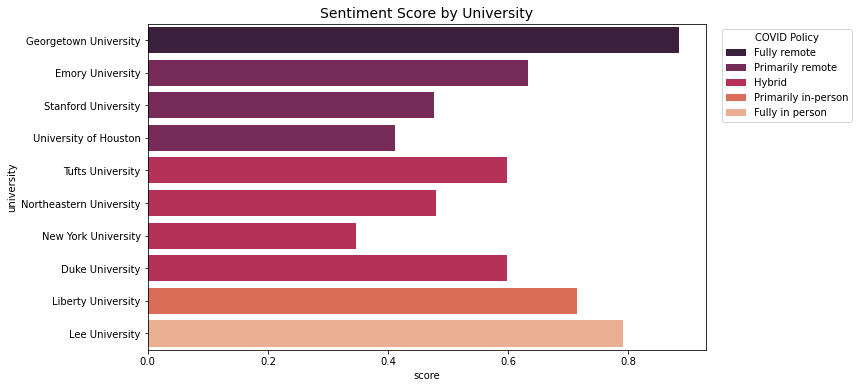

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Construct plot
plt.figure(figsize=(10,6))
sns.barplot(x = "score", y = "university", data = school_type_df, hue = 'policy', dodge=False, palette='rocket')
plt.title('Sentiment Score by University', size=14)
plt.legend(title ='COVID Policy', bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()